In [116]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)

!pip install pandas scikit-learn transformers torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

* **Dataset**- It contains questions covering topics relevant to financial analysis, company operations, and strategic insights, making it a valuable resource for researchers, data scientists, and finance professionals. (The dataset has been taken from Kaggle (https://www.kaggle.com/datasets/yousefsaeedian/financial-q-and-a-10k))


* **Methodolology -** I observed the questions(/queries) in the dataset, picked some keywords which will likely cover all the intents. I filtered the dataset to keep a total of random 60 sentences.


* **Data labelling -** Data was labelled using ChatGPT first and then it was checked manually.







In [117]:
# loading and observing the dataset
df = pd.read_csv("/content/Financial-QA-10k.csv")
df.head(10)

,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before expanding to other computationally intensive fields?,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.",NVDA,2023_10K
1,What are some of the recent applications of GPU-powered deep learning as mentioned by NVIDIA?,"Recent applications of GPU-powered deep learning include recommendation systems, large language models, and generative AI.","Some of the most recent applications of GPU-powered deep learning include recommendation systems, which are AI algorithms trained to understand the preferences, previous decisions, and characteristics of people and products using data gathered about their interactions, large language models, which can recognize, summarize, translate, predict and generate text and other content based on knowledge gained from massive datasets, and generative AI, which uses algorithms that create new content, including audio, code, images, text, simulations, and videos, based on the data they have been trained on.",NVDA,2023_10K
2,What significant invention did NVIDIA create in 1999?,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined modern computer graphics and established NVIDIA as the leader in computer graphics.,NVDA,2023_10K
3,How does NVIDIA's platform strategy contribute to the markets it serves?,"NVIDIA's platform strategy brings together hardware, systems, software, algorithms, libraries, and services to create unique value.","NVIDIA has a platform strategy, bringing together hardware, systems, software, algorithms, libraries, and services to create unique value for the markets we serve.",NVDA,2023_10K
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the parallel processing capabilities of GPUs for general purpose computing.,"With our introduction of the CUDA programming model in 2006, we opened the parallel processing capabilities of our GPU for general purpose computing.",NVDA,2023_10K
5,What industries use NVIDIA's GPUs and software for automation?,"NVIDIA's GPUs and software are used for automation in various industries including transportation, healthcare, financial services, professional design, movies, and building products design.",A rapidly growing number of enterprises and startups across a broad range of industries use our GPUs and software to bring automation to the products and services they build. The transportation industry is turning to our platforms for autonomous driving; the healthcare industry is leveraging them for enhanced medical imaging and acceleration of drug discovery; and the financial services industry is using them for fraud detection. Professional designers use our GPUs and software to create visual effects in movies and to design buildings and products ranging from cell phones to commercial aircraft.,NVDA,2023_10K
6,Why did NVIDIA and SoftBank terminate their Share Purchase Agreement for acquiring Arm Limited?,NVIDIA and SoftBank terminated their Share Purchase Agreement due to significant regulatory challenges that prevented the completion of the transaction.,"Termination of the Arm Share Purchase Agreement In February 2022, NVIDIA and SoftBank Group Corp., or SoftBank, announced the termination of the Share Purchase Agreement whereby NVIDIA would have acquired Arm Limited, or Arm, from SoftBank. The parties agreed to terminate because of significant regulatory challenges preventing the completion of the transaction.",NVDA,2023_10K
7,What amount did NVIDIA record as an acquisition termination cost in fiscal year 2023?,NVIDIA recorded an acquisition termination cost of $1.35 billion in fiscal year 2023.,We recorded an acquisition termination cost of $1.35 billion in fiscal year 2023 reflecting the write-off of the prepayment provided at signing.,NVDA,2023_10K
8,What does the NVIDIA computing platform foc

In [118]:
df = df.rename(columns = {'question':'query'})
df

,query,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before expanding to other computationally intensive fields?,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.",NVDA,2023_10K
1,What are some of the recent applications of GPU-powered deep learning as mentioned by NVIDIA?,"Recent applications of GPU-powered deep learning include recommendation systems, large language models, and generative AI.","Some of the most recent applications of GPU-powered deep learning include recommendation systems, which are AI algorithms trained to understand the preferences, previous decisions, and characteristics of people and products using data gathered about their interactions, large language models, which can recognize, summarize, translate, predict and generate text and other content based on knowledge gained from massive datasets, and generative AI, which uses algorithms that create new content, including audio, code, images, text, simulations, and videos, based on the data they have been trained on.",NVDA,2023_10K
2,What significant invention did NVIDIA create in 1999?,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined modern computer graphics and established NVIDIA as the leader in computer graphics.,NVDA,2023_10K
3,How does NVIDIA's platform strategy contribute to the markets it serves?,"NVIDIA's platform strategy brings together hardware, systems, software, algorithms, libraries, and services to create unique value.","NVIDIA has a platform strategy, bringing together hardware, systems, software, algorithms, libraries, and services to create unique value for the markets we serve.",NVDA,2023_10K
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the parallel processing capabilities of GPUs for general purpose computing.,"With our introduction of the CUDA programming model in 2006, we opened the parallel processing capabilities of our GPU for general purpose computing.",NVDA,2023_10K
...,...,...,...,...,...
6995,What was the interest rate for the 5.400% Senior Notes due in 2028 after accounting for unamortized original issue discount and deferred financing costs?,5.400%,"The 5.400% Senior Notes due in 2028 have an interest rate of 5.400%, net of unamortized original issue discount and deferred financing costs of $11 and $13, respectively.",LVS,2023_10K
6996,"What changes were made to the LVSC Revolving Credit Agreement according to the Fourth Amendment enacted on January 30, 2023?","The Fourth Amendment to the LVSC Revolving Credit Agreement on January 30, 2023, included changes such as determining consolidated adjusted EBITDA on a year-to-date annualized basis, extending the minimum liquidity requirement to December 31, 2023, and extending restrictions on dividends and distributions unless liquidity exceeds $1.0 billion on a pro forma basis after such distributions, to the same date.","On January 30, 2023, LVSC entered into amendment No. 4 (the “Fourth Amendment”) with lenders to the LVSC Revolving Credit Agreement. Pursuant to the Fourth Amendment, the existing LVSC Revolving Credit Agreement was amended to (a) determine consolidated adjusted EBITDA on a year-to-date annualized basis during the period commencing on the effective date and ending on and including December 31, 2023, as follows: (i) for the fiscal quarter ended March 31, 2023, consolidated adjusted EBITDA for such fiscal quarter multiplied by four, (ii) for the fiscal quarter ended June 30, 2023, consolidated adjusted EBITDA for such fiscal quarter and the immediately preceding fiscal quarter multiplied by two, and (iii) for the fiscal quarter ended September 30, 2023, consolidated adjusted EBITDA for such fiscal quarter and the two immediately preceding fiscal quarters, multiplied by four-thirds; (b) extend the period during which LVSC is required to maintain a specifi

In [119]:
# I observed a few keyword which may likely cover queries for all intents
keywords = ['market', 'cost', 'amount', 'fiscal', 'shareholder', 'dividend', 'revenue', 'fund', 'compensat', 'repurchase', 'stock', 'growth', 'compare', 'increase', 'decrease']

In [120]:
# Filter rows containing any of the keywords
pattern = '|'.join(keywords)

filtered_df = df[df['query'].str.contains(pattern, case=False, na=False)]


df_no_duplicates = filtered_df.drop_duplicates(subset=['query'], keep='first')
df_no_duplicates.describe()

,query,answer,context,ticker,filing
count,2359,2358,2359,2359,2359
unique,2359,2223,2331,68,1
top,How does NVIDIA's platform strategy contribute to the markets it serves?,Pages 44 through 121,"ITEM 11. EXECUTIVE COMPENSATION Information regarding our executive compensation required by this item will be contained in our 2023 Proxy Statement under the captions “Executive Compensation”, “Compensation Committee Interlocks and Insider Participation”, “Director Compensation” and “Compensation Committee Report,” and is hereby incorporated by reference.",JNJ,2023_10K
freq,1,12,4,83,2359


In [121]:
# select 60 sentences in random order
random_rows = df['query'].sample(n=60, random_state=1)  # random_state for reproducibility

# Create a new DataFrame from the selected rows
filtered_df = pd.DataFrame(random_rows)

*I used ChatGPT to generate labels in a batch of 10 or more sentences- I noticed it is simply giving me a same repeated pattern (some labels were right too) so I used it to create a new column and later manually corrected it*

# **Labels:**

**Metric enquiry**

**Historical Data**

**Forecasting & Predictions**

**Fundamental Data Request**

**Comparative Analysis**

**News Impact**

# SOME IMP POINTERS ON DATA LABELLING
# Overlapping labels

Many sentences had a couple or more suitable labels,  for example -
1. How much did Resource Industries' profit increase in 2023 and what were the main contributing factors?
[HISTORICAL DATA, COMPARATIVE ANALYSIS]

2. What was the net cash used in investing activities for the year ended December 31, 2023, and what were the primary components of this expenditure?
[HISTORICAL DATA, METRIC INQUIRY]

In case of overlapping labels, I tried to use the label that has lesser frequency (It has not been strictly followed)

#'Other' label

A suggestion is that a new label 'Other' can be incorporated, for queries like the following-

1. How is the Financial Statements and Supplementary Data section numbered in some documents?

It does not neately fall under 'Fundamental Data Request' but has been labelled as that because it is asking for something related to a financial document. However, a new category 'Other' may help as-

      * It is more suitable
      * It will divide the frequency count for 'Fundamental Data Request' which is currently the majority, making the data more balanced.

 # Noise in the data

 Some queries were not fitting into any labels and are seen as noise in the data.

In [122]:
labels = [
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
     "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",
    "News Impact", "Metric Inquiry", "Fundamental Data Request",

]
len(labels)

60

In [123]:
# add labels as a new col
filtered_df['intent'] = labels

final_df = filtered_df[['query', 'intent']]
final_df

,query,intent
2305,In how many countries are Eli Lilly and Company's products sold?,News Impact
4388,"What was the amount of unrecognized tax benefits recorded as of January 28, 2023?",Metric Inquiry
1686,What section of the Annual Report on Form 10-K contains the consolidated financial statements and accompanying notes?,Fundamental Data Request
4945,What are the expected impacts of CORSIA and ETS on FedEx Express's operations?,News Impact
4197,What does Part IV Item 15 include in a financial document?,Metric Inquiry
1651,Where are the consolidated financial statements and accompanying notes listed in the Annual Report on Form 10-K?,Fundamental Data Request
1528,In which item and part of a financial document would you find information on legal proceedings?,News Impact
6346,What are the consequences of the company failing to protect its intellectual property?,Metric Inquiry
6189,How are expected credit losses estimated for securities according to their accounting treatment?,Fundamental Data Request
5389,What was the adjustment for Cadillac dealer strategy in 2023?,News Impact


In [124]:
# downloading the file for a manual check and edit
final_df.to_csv('final_df.csv', index=False)
files.download("final_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
# the final dataset with corrected labels
updated_dataset = pd.read_csv('/content/final_df.csv')

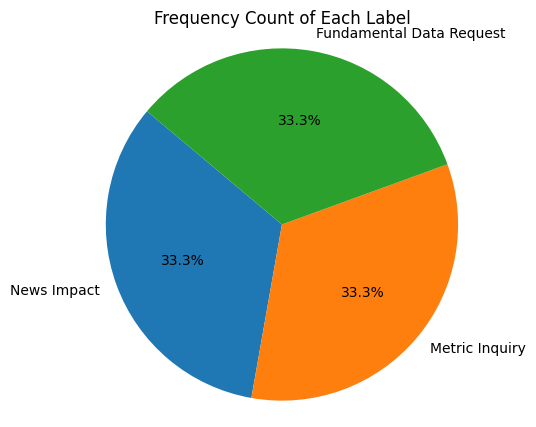


There is a class imbalance


In [126]:
# frequency count for each label
label_counts = updated_dataset['intent'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Frequency Count of Each Label')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

print("\nThere is a class imbalance")

In [127]:
X = updated_dataset['query']  # Features
y = updated_dataset['intent']  #labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training target set shape:", y_train.shape)
print("Testing target set shape:", y_test.shape)

Training feature set shape: (48,)
Testing feature set shape: (12,)
Training target set shape: (48,)
Testing target set shape: (12,)


In [129]:
vectorizer = TfidfVectorizer()
label_encoder = LabelEncoder()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [130]:
# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Important: only transform test labels


In [131]:
# Train the model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Model Performance and enhancement
* The model shows strong precision for "Forecasting & Predictions" (100%) but fails to detect many of these instances (25% recall). In contrast, it has good recall for "Comparative Analysis" (100%) but low precision (45%).

* The overall metrics indicate some imbalance in class performance, with one class being identified perfectly while the other struggles.

**Enhancement** - *The dataset is imbalanced and the minority class can be augmented for improvement.*

In [132]:
# Evaluate the model
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, labels=np.unique(y_pred)))

                          precision    recall  f1-score   support

Fundamental Data Request       0.33      1.00      0.50         2
          Metric Inquiry       0.17      0.50      0.25         2

               micro avg       0.25      0.75      0.38         4
               macro avg       0.25      0.75      0.38         4
            weighted avg       0.25      0.75      0.38         4

